# System Demo
- Paper: Towards interactive robotics: Zero-shot action sequence generation using reasoning through ChatGPT
- This system presents a take on a ReAct model (more info: https://react-lm.github.io/)
- Creator: Andrei Dragomir

Add "fancy" version of the system demo here.
pip install tts
follow this guide to plug in text-to-speech https://www.youtube.com/watch?v=MYRgWwis1Jk
!! call tts with gpu=True to use gpu


## Imports and initialization

In [1]:
import os
import tiktoken
import time
import numpy as np
import matplotlib.pyplot as plt
from gpt_controller.config import *
from gpt_controller.util.models import *
from gpt_controller.util.labels import *
from gpt_controller.cognition.machine import Machine
from gpt_controller.playground.environment import Environment

environment = Environment('kitchen')
machine = Machine(environment)

## Testing chatGPT

#### Benchmarks

In [2]:
# Function to get prompt deck from the prompt directory as a dictionary
# Returns a dictionary of prompt names and prompts
def get_prompt_deck() -> dict[str, str]:
    prompt_deck = {}
    for root, dirs, files in os.walk(PROMPT_PATH):
        for name in files:
            if name.endswith(".txt"):
                prompt_location = os.path.abspath(os.path.join(root, name))
                try:
                    with open(prompt_location, "r") as f:
                        prompt = f.read()
                        f.flush()
                    prompt_deck[name] = prompt
                except OSError as e:
                    print("Error: Prompt {} could not be loaded with reason: {}".format(name, e.args[0]))
                    continue
    return prompt_deck    
        
def num_tokens_prompt(prompt: str):
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(CHATGPT_MODEL)
    num_tokens = len(encoding.encode(prompt))
    return num_tokens

In [3]:
for name, prompt in get_prompt_deck().items():
    num_tokens = num_tokens_prompt(prompt)
    if num_tokens == 0:
        continue
    print("Prompt: {} \nNumber of tokens: {}\n".format(name, num_tokens))

Prompt: decision_making.txt 
Number of tokens: 582

Prompt: label_input.txt 
Number of tokens: 117

Prompt: memorize_object.txt 
Number of tokens: 253

Prompt: function_similarity.txt 
Number of tokens: 199

Prompt: act.txt 
Number of tokens: 94

Prompt: get_goal_predicates.txt 
Number of tokens: 389

Prompt: question_about_context.txt 
Number of tokens: 384

Prompt: segment_input.txt 
Number of tokens: 371



#### Targeted prompt tests

- This section provides tests for specific prompts that are used in the system.
- The tests are done by running the prompt through chatGPT and checking if the output is the expected one.

##### Labelling

- You can make sets of prompts for a specific type of label and run them all at once using the helper function `run_label_tests()`.
    - You must pass a list of strings that you want to test
    - You must specify what label you want to test.
    - The function returns an accuracy score of the tests.

In [4]:
def run_label_tests(prompt_deck : list[tuple[Label, str]], expected_label : Label):
    right_answers = 0
    for label, prompt in prompt_deck:
        provided_label = machine.label(prompt, expected_label.__class__)
        while provided_label is None:
            provided_label = machine.label(prompt, expected_label.__class__)
        time.sleep(1)
        if provided_label == label:
            right_answers += 1
        else:
            print("Prompt: {}\nExpected Label: {}\nProvided Label: {}\n".format(prompt, expected_label, provided_label))
    return right_answers/len(prompt_deck)

User Input Type labelling

In [5]:
task_set = [
    "Peel 5 potatoes.",
    "Stir the pot of soup.",
    "Chop onions.",
    "Pour ingredients into a mixing bowl.",
    "Wash fruits and vegetables.",
    "Measure ingredients for the recipe.",
    "Open the jar of jam.",
    "Grate cheese.",
    "Preheat the oven to a specific temperature.",
    "Set a timer for cooking or baking.",
    "Mix ingredients together in a bowl.",
    "Slice some bread.",
    "Pour liquids into containers.",
    "Clean countertop with the sponge.",
    "Load the dishwasher.",
    "Retrieve items from cabinets or shelves.",
    "Remove hot dishes from the oven.",
    "Garnish plates with herbs or sauces.",
    "Arrange food on a serving platter.",
    "Brew a cup of coffee or tea.",
    "Clean kitchen utensils.",
    "Wipe spills from the floor.",
    "Refill water bottles or containers.",
    "Organize pantry items.",
    "Dispose of food waste."
]
questions_env_set = [
    "What is the size of the tomato?",
    "What is the color of the tomato?",
    "Where is the tomato?",
    "How many tomatoes are in the fridge?",
    "What cutleries do you have access to?",
    "What is the length of the knife?",
    "What is the material of the knife?",
    "What can be found inside the fridge?",
    "Where is the fridge?",
    "Are there any perishable items that need to be refrigerated?",
    "Where can you cut the tomato?",
    "Where can you find the knife?",
    "What ingredients do you have access to?",
    "What is the material of the cutting board?",
    "What is the size of the cutting board?",
    "Do you have access to a cutting board?",
    "Is there any place you can warm up the food?",
    "Is there any place you can cook the food?",
    "Are you missing any ingredients for the recipe?",
    "Are there any ingredients that need to be refrigerated?",
    "Where is the stove?",
    "Where is the oven?",
    "What is the size of the oven?",
    "Does the pot fit in the oven?",
    "Is the oven on?"
]
questions_general_set = [
    "How big is a tomato?",
    "What is the average length of a knife?",
    "What is the average size of a cutting board?",
    "Where can you buy a tomato?",
    "What do you use a knife for?",
    "What do you use a cutting board for?",
    "What do you use a pot for?",
    "What do you use a pan for?",
    "What are the ingredients for a caesar salad?",
    "What are the ingredients for a tomato soup?",
    "What are the ingredients for a grilled cheese sandwich?",
    "Do you need a knife to cut a tomato?",
    "Do you need a cutting board to cut a tomato?",
    "Can you cut a tomato with a knife?",
    "Can you cut a tomato with a butter knife?",
    "Is a tomato a fruit?",
    "Is a tomato a vegetable?",
    "Is a tomato a fruit or a vegetable?",
    "What are healthy receipes?",
    "What are some healthy receipes?",
    "What are some healthy receipes for breakfast?",
    "What do you need to make a caesar salad?",
    "How much meat should you eat per day?",
    "How many calories should you eat per day?",
    "How many calories are in a tomato?"
]
methodology_set = [
    "You can use a knife to cut a tomato.",
    "You can use a cutting board to cut a tomato.",
    "You should put the tomato on the cutting board before cutting it.",
    "You should take the tomato out of the fridge before cutting it.",
    "You should wash the tomato before cutting it.",
    "You can open the fridge to get the tomato.",
    "You can open the drawer to get the knife.",
    "You should put a little pressure on the knife when cutting the tomato.",
    "You should cut the tomato in half.",
    "You should cut the tomato into slices.",
    "Use the knife to cut the tomato.",
    "Use the cutting board to cut the tomato.",
    "You can use the vegetables in the fridge to make a salad.",
    "You can use the ingredients in the fridge to make a salad.",
    "When you are done cutting the tomato, you should put the knife back in the drawer.",
    "When you cut the vegetables, you should put them in the bowl.",
    "You can pick up the knife from the handle.",
    "You should cut the tomatoes first before cutting the onions.",
    "You should cut all the vegetables before cooking them.",
    "Its possible to cut the tomato with a butter knife.",
    "You should fill the pot with water before putting it on the stove.",
    "You should put the pot on the stove before turning it on.",
    "Turn on the stove before putting the pot on it.",
    "Make sure you turn off the stove before leaving the kitchen.",
    "Make sure to have a firm grip on the knife when cutting the tomato."
]
limitations_set = [
    "You can't use a knife to cut a tomato.",
    "You can only use a knife to cut a tomato.",
    "You can use only vegetables in the fridge to make a salad.",
    "You can't use the ingredients in the fridge to make a salad.",
    "You must not cut the tomato on anything else other than a cutting board.",
    "You must not cut the tomato on the counter.",
    "You must ask me to use the knife.",
    "You cannot use the knife without my permission.",
    "You cannot open the fridge",
    "You cannot use the stove.",
    "You can only take one tomato from the fridge.",
    "You can fit only one tomato on the cutting board.",
    "You can only cut the tomato into 2 pieces.",
    "You must avoid the carpet when carrying the knife.",
    "You must warn me before using the knife.",
    "Do not use the knife without my permission.",
    "Do not turn on the stove yourself, ask me to do it.",
    "You are not capable of using the knife.",
    "You have to stay only in the kitchen.",
    "You cannot leave the kitchen.",
    "Don't move around with the knife.",
    "If you drop anything on the floor, you cannot pick it up.",
    "The sink is not working.",
    "The stove is not working.",
    "The drawer containing the knife is locked."
]
object_info_set = [
    "The tomato is in the fridge.",
    "The knife is in the drawer.",
    "The tomato on the cutting board is cuttable.",
    "The vegetables in the fridge are already cut.",
    "The melon weighs around 1 kilogram.",
    "The knife is made of metal.",
    "The knife has a handle that you can hold onto.",
    "There is a tomato on the cutting board.",
    "There are 2 tomatoes in the fridge.",
    "The trash can is in the corner of the kitchen.",
    "The trash can is made of plastic.",
    "The plate for the salad is in the cabinet.",
    "The plate is pretty big.",
    "The plate does not fit in the microwave.",
    "A tomato can be found in the fridge.",
    "All the ingredients for the salad can be found in the fridge.",
    "The fridge is empty.",
    "The size of the table is 1 meter by 2 meters.",
    "The kitchen counter is 1 meter high.",
    "The kitchen counter is easily scratchable.",
    "The kitchen counter is made of wood.",
    "The rack can only hold 2 plates.",
    "The rack is not fixed to the wall.",
    "The plate is fairly heavy.",
    "The vegetables in the fridge can be cut."
]

labelled_task_set = [(UserInputLabel.TASK, prompt) for prompt in task_set]
labelled_questions_env_set = [(UserInputLabel.QUESTION_ENV_KNOWLEDGE, prompt) for prompt in questions_env_set]
labelled_questions_general_set = [(UserInputLabel.QUESTION_GEN_KNOWLEDGE, prompt) for prompt in questions_general_set]
labelled_methodology_set = [(UserInputLabel.METHODOLOGY, prompt) for prompt in methodology_set]
labelled_limitations_set = [(UserInputLabel.LIMITATION, prompt) for prompt in limitations_set]
labelled_object_info_set = [(UserInputLabel.OBJECT_INFORMATION, prompt) for prompt in object_info_set]

data_sets = [labelled_task_set, labelled_questions_env_set, labelled_questions_general_set, labelled_methodology_set, labelled_limitations_set, labelled_object_info_set]
plot_data = []
for i in range(0,5):
    tmp_data = []
    for data in data_sets:
        tmp_data.append(run_label_tests(data, data[0][0]))
    plot_data.append(tmp_data)

Prompt: What cutleries do you have access to?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.OBJECT_INFORMATION

Prompt: What is the length of the knife?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.QUESTION_GEN_KNOWLEDGE

Prompt: What is the material of the knife?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.OBJECT_INFORMATION

Prompt: What can be found inside the fridge?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.OBJECT_INFORMATION

Prompt: What ingredients do you have access to?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.QUESTION_GEN_KNOWLEDGE

Prompt: What is the material of the cutting board?
Expected Label: UserInputLabel.QUESTION_ENV_KNOWLEDGE
Provided Label: UserInputLabel.OBJECT_INFORMATION

Prompt: Do you have access to a cutting board?
Expected Label: UserInputLabel.QUESTION_E

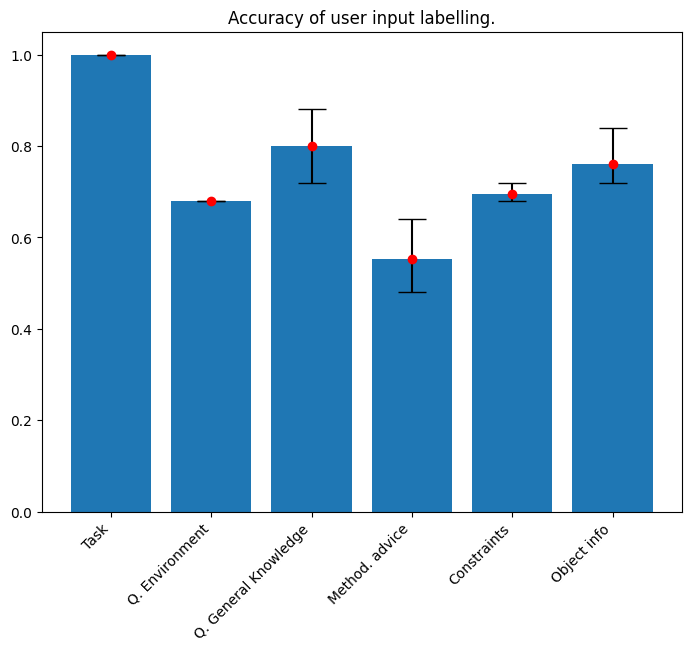

[1.0, 0.68, 0.8, 0.552, 0.696, 0.76]
[1.0, 0.68, 0.72, 0.48, 0.68, 0.72]
[1.0, 0.68, 0.88, 0.64, 0.72, 0.84]


In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Task', 'Q. Environment', 'Q. General Knowledge', 'Method. advice', 'Constraints', 'Object info']
accuracies = list(zip(*plot_data))

means = [sum(accuracy_set)/len(accuracy_set) for accuracy_set in accuracies]
max_values = [max(accuracy_set) for accuracy_set in accuracies]
min_values = [min(accuracy_set) for accuracy_set in accuracies]

min_err = [means[i] - min_values[i] for i in range(0, len(means))]
max_err = [max_values[i] - means[i] for i in range(0, len(means))]
# Plot the error bars
ax.bar(labels, means)
ax.errorbar(labels, means, yerr=[min_err, max_err],
            fmt='o', color='red', ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
plt.title('Accuracy of user input labelling.')
plt.show()

print(means)
print(min_values)
print(max_values)

Generated task labelling

In [28]:
manipulation_tasks = [
    "Pick up the knife.",
    "Slice the tomato.",
    "Slice the cucumber.",
    "Slice the lettuce.",
    "Grab the plate.",
    "Place the tomato on the plate.",
    "Close the refrigerator.",
    "Place the tomato on the cutting board.",
    "Cut the tomato.",
    "Open the drawer.",
    "Place the knife in the drawer.",
    "Close the drawer.",
    "Lift the cutting board.",
    "Turn on the stove.",
    "Place the pot on the stove.",
    "Fill the pot with water.",
    "Hold the pot.",
    "Squeeze the lemon.",
    "Store the lemon in the fridge.",
    "Pat the lettuce dry."
]
navigation_tasks = [
    "Move to the refrigerator.",
    "Move to the counter.",
    "Go to the stove.",
    "Get close to the sink.",
    "Approach the fridge.",
    "Move with the pot to the sink.",
    "Move to the side.",
    "Bring the pot to the stove.",
    "Go slowly towards the counter.",
    "Step back."
]
perception_tasks = [
    "Look for vegetables for the salad.",
    "Look for the knife.",
    "Search for the cutting board.",
    "Find the pot.",
    "Locate the stove.",
    "Look around the kitchen.",
    "Scan the fridge contents.",
    "Count the number of tomato slices.",
    "Detect the objects on the counter.",
    "Search for a knife in the drawer."
]
inquiry_tasks = [
    "Ask where the knife could be located.",
    "Ask if the tomato is cuttable.",
    "Ask if the stove is working.",
    "Ask the user to turn on the stove.",
    "Ask if the knife held is good for cutting.",
    "Ask where the cutting board is.",
    "Ask how long the vegetables should be cooked.",
    "Ask the user what to do next.",
    "Ask the user which tomato they want.",
    "Ask how to open the drawer."
]
cognitive_tasks = [
    "Recall any knowledge about the location of the ingredients.",
    "Recall where the knife is.",
    "Memorize the location of the cutting board.",
    "Remember the location of the stove.",
    "Think about which ingredients are needed for the salad.",
    "Decide which tomato to use.",
    "Estimate how long the vegetables should be cooked.",
    "Estimate the weight of the melon.",
    "Calculate the number of slices needed.",
    "Evaluate how many tomatoes are sufficient."
]

labelled_manipulation_tasks = [(TaskLabel.MANIPULATION, prompt) for prompt in manipulation_tasks]
labelled_navigation_tasks = [(TaskLabel.NAVIGATION, prompt) for prompt in navigation_tasks]
labelled_perception_tasks = [(TaskLabel.PERCEPTION, prompt) for prompt in perception_tasks]
labelled_inquiry_tasks = [(TaskLabel.INQUIRY, prompt) for prompt in inquiry_tasks]
labelled_cognitive_tasks = [(TaskLabel.COGNITION, prompt) for prompt in cognitive_tasks]

data_sets_2 = [labelled_manipulation_tasks, labelled_navigation_tasks, labelled_perception_tasks, labelled_inquiry_tasks, labelled_cognitive_tasks]
plot_data_2 = []
for i in range(0,5):
    tmp_data_2 = []
    for data in data_sets_2:
        tmp_data_2.append(run_label_tests(data, data[0][0]))
    plot_data_2.append(tmp_data_2)


Prompt: Bring the pot to the stove.
Expected Label: TaskLabel.NAVIGATION
Provided Label: TaskLabel.MANIPULATION

Prompt: Look for the knife.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.MANIPULATION

Prompt: Search for the cutting board.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.NAVIGATION

Prompt: Find the pot.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.NAVIGATION

Prompt: Locate the stove.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.NAVIGATION

Prompt: Look around the kitchen.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.NAVIGATION

Prompt: Count the number of tomato slices.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.MANIPULATION

Prompt: Search for a knife in the drawer.
Expected Label: TaskLabel.PERCEPTION
Provided Label: TaskLabel.MANIPULATION

Prompt: Ask if the tomato is cuttable.
Expected Label: TaskLabel.INQUIRY
Provided Label: TaskLabel.COGNITION

Prompt: Ask wh

[0.0, 0.08000000000000007, 0.08000000000000002, 0.039999999999999925, 0.02000000000000013]
[0.0, 0.019999999999999907, 0.019999999999999962, 0.06000000000000005, 0.07999999999999985]


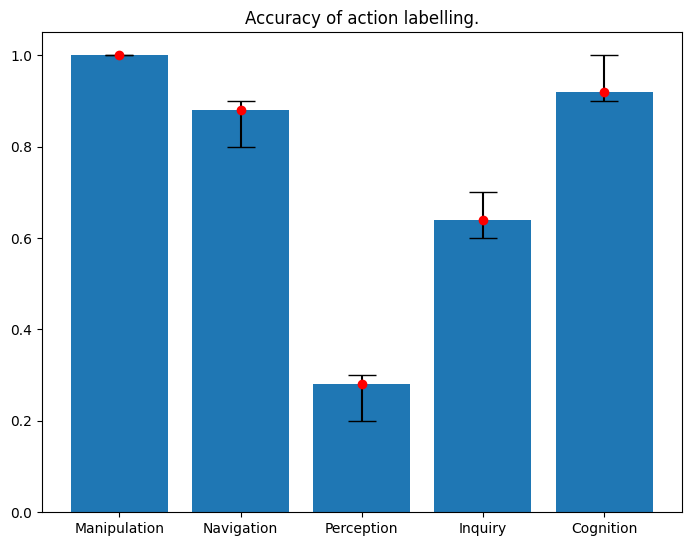

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Manipulation', 'Navigation', 'Perception', 'Inquiry', 'Cognition']
accuracies_2 = list(zip(*plot_data_2))

means = [sum(accuracy_set)/len(accuracy_set) for accuracy_set in accuracies_2]
max_values = [max(accuracy_set) for accuracy_set in accuracies_2]
min_values = [min(accuracy_set) for accuracy_set in accuracies_2]

min_err = [means[i] - min_values[i] for i in range(0, len(means))]
max_err = [max_values[i] - means[i] for i in range(0, len(means))]

print(min_err)
print(max_err)
# Plot the error bars
ax.bar(labels, means)
ax.errorbar(labels, means, yerr=[min_err, max_err],
            fmt='o', color='red', ecolor='black', capsize=10)

plt.title('Accuracy of action labelling.')
plt.show()

##### Information Recall

In [ ]:
machine.fill_memory_with_objects(environment.objects, basic_knowledge=True)

input_string = "What round fruits do you have available?"

machine.recall(input_string)
print(machine.task_stack[-1].conclusion)

##### Information Estimation

In [ ]:
machine.fill_memory_with_objects(environment.objects, basic_knowledge=True)

input_string = "What is the weight of the knife?"

machine.recall(input_string)
print(machine.task_stack[-1].conclusion)

## Future Work

- Implementing a ReAct system for interfacing with chatGPT
    - ReAct is a system that allows for the generation of actions from a given state.
    - It is a system that is trained on a dataset of actions and states.

    **Inspiration**
    https://react-lm.github.io/

- Implement defensive json parsing for the chatGPT system
    - Use a json schema to validate the input json
    - Use a library like `Langchain` or `llmparser` to recover from slightly malformed json outputs